In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import ArtistAnimation

%matplotlib inline

#Setting constants 
ep_0 = 8.8541878*(10**(-12))
mew_0 = 4*(np.pi)*(10**(-7))
c0 = 299792458

In [2]:
#Grid Resolution
ds = 0.1

#Grid Size
x_steps = 200
x_len = (x_steps-1)*ds
x_axis = y_axis =np.linspace(0, x_len, x_steps)

y_steps = 200
y_len = (y_steps-1)*ds
y_axis =np.linspace(0, y_len, y_steps)

#Setting environment parameters
mew_r = ep_r = n = np.ones((x_steps,y_steps))
mew_r[:,y_steps//2:-4] = 2.0   # relative permeability in part of the grid
ep_r[:,y_steps//2:-4]  = 2.0   # relative permittivity in part of the grid
n = np.sqrt(mew_r*ep_r)  # refractive index of the grid

σ = np.zeros((x_steps,y_steps))
σ[:,y_steps//2:-4] = 10**(-3)  # electrical conductivity in part of the grid
    
#Time Step (using courant stability condition)
dt = ds/(np.sqrt(2.0)*c0)    #dt is chosen so that the magnitude of c0*dt and dx have the same order of magnitude 

#Time Period of simulation
t_steps = 500
timePeriod = (t_steps-1)*dt
t_axis = np.linspace(0, timePeriod, t_steps)

#Gaussian source (impulse)
#Source Parameters
tau = 10*dt
t0  = 10*tau
#Generating Electric Field source over time
Es = np.exp(-((t_axis-t0)/tau)**2) 

#Update Coefficients for fdtd (chosen basedon Maxwell's equations with normalized Electric and Magnetic field values)
mH = (-dt*c0/(mew_r*ds))

mE1 = (2*ep_0*ep_r - σ*dt)/(2*ep_0*ep_r + σ*dt)
mE2 = 2*ep_0*c0*dt/(ds*(2*ep_0*ep_r + dt*σ))

In [3]:
"""
Simulation is done in 2D over XY plane. (d/dz is assumed to be 0, i.e; materials extended infinitely along z axis and no change is observed)
    Expanding Mexwell's equations given this conditions retuens two independant modes of EM waves
    Ez mode of EM wave is simulated

Dirichlet Boundary Conditions are applied 
    Everything outside the simulated grid is set to 0, and so the EM wave is reflected back into the grid

Loss is introduced by adding electrical conductivity σ, and update coefficients for electric field E are modified accordingly
"""

HxOverTime = HyOverTime = EzOverTime = np.zeros((1, x_steps, y_steps)) 

for t in range(1,t_steps,1):

    Hx = HxOverTime[t-1]
    Hy = HyOverTime[t-1]
    Ez = EzOverTime[t-1]

    Hx[:,:-1] += mH[:,:-1]*(Ez[:,1:]-Ez[:,:-1])  #Change in Ez over y
    Hx[:,-1] += mH[:,-1]*(0-Ez[:,-1]) #Boundary Condition

    HxOverTime = np.append(HxOverTime, np.array([Hx]), axis=0)
    
    Hy[:-1,:] -= mH[:-1,:]*(Ez[1:,:]-Ez[:-1,:])  #Change on Ez over x
    Hy[-1,:] -= mH[-1,:]*(0-Ez[-1,:])  #Boundary Condition

    HyOverTime = np.append(HyOverTime, np.array([Hy]), axis=0)

    CHz = np.zeros((x_steps,y_steps))  #z component of curl of H
    CHz[1:,:] += (Hy[1:,:]-Hy[:-1,:])  #Change in Hy over x
    CHz[0,:] += (Hy[0,:]-0)  #Boundary Condition
    CHz[:,1:] -= (Hx[:,1:]-Hx[:,:-1])  #Change in Hx over y
    CHz[:,0] -= (Hx[:,0]-0)  #Boundary Condition
    CHz[0,0] += Hy[0,0] - Hx[0,0]  #Boundary Condition
    Ez = mE1[:,:]*Ez + mE2[:,:]*CHz[:,:]
    
    Ez[99,60] += Es[t]  #injecting source at a point in the grid
    
    EzOverTime = np.append(EzOverTime, np.array([Ez]), axis=0)

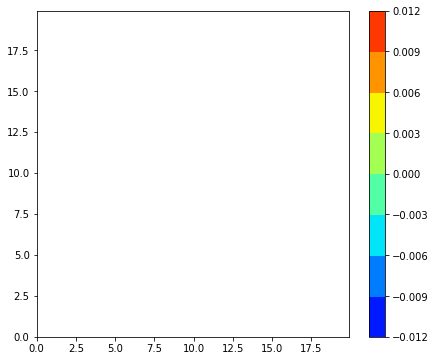

In [4]:
#Animation (Ez Over XY plane - Contour)

fig = plt.figure(figsize=(7,6))
ims = []

for t in range(0, int(t_steps), 5):
    im = plt.contourf(x_axis, y_axis, EzOverTime[t].T, cmap= 'jet', vmax=0.015,vmin=-0.015)
    ims.append(im.collections)

cbar = plt.colorbar(im)

ani = ArtistAnimation(fig, ims, interval=150, repeat=True)

ani.save("EzOverXY.gif", writer='imagemagick') 

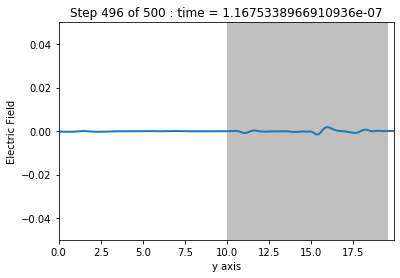

In [6]:
#Animation (Ez Over Y axis)

fig = plt.figure(figsize=(6,4))
ax = plt.axes(xlim=(0, x_len), ylim = (-0.05,0.05))

#The region with different refractive index is colored silver
for i in range(0, y_steps, 1):
    if n[100,i] == 1.0:
        plt.axvspan(i*ds, (i+1)*ds, facecolor='w')
    else:
        plt.axvspan(i*ds, (i+1)*ds, facecolor='silver')

ax.set_xlabel('y axis')
ax.set_ylabel('Electric Field')

line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return line,

#The E field over z acis is plotted every 10th time step
def animate(t):
    x = y_axis
    y = EzOverTime[5*t,100]
    plt.title("Step " + str(5*t+1) + " of " + str(t_steps)+ " : time = " + str(5*t*dt))
    line.set_data(x, y)
    return line,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=int(t_steps/5), interval=1, blit=True)

anim.save("EzOverY.gif", writer='imagemagick')

Based on Reference material on FDTD analysis from https://empossible.net/academics/emp5304/